In [29]:
# Read air quality data for all cities, add a 'city' column, and combine everything into one dataset.
import pandas as pd

files = {
    "Islamabad": "islamabad_complete_data.xlsx",
    "Karachi": "karachi_complete_data.xlsx",
    "Lahore": "lahore_complete_data.xlsx",
    "Peshawar": "peshawar_complete_data.csv",
    "Quetta": "quetta_complete_data.csv"
}

dfs = []

for city, file in files.items():
    if file.endswith(".xlsx"):
        df = pd.read_excel(file)
    else:
        df = pd.read_csv(file)

    df['city'] = city
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)


In [30]:
df.columns


Index(['datetime', 'main.aqi', 'components.co', 'components.no',
       'components.no2', 'components.o3', 'components.so2', 'components.pm2_5',
       'components.pm10', 'components.nh3', 'temperature_2m',
       'relative_humidity_2m', 'dew_point_2m', 'precipitation',
       'surface_pressure', 'wind_speed_10m', 'wind_direction_10m',
       'shortwave_radiation', 'city'],
      dtype='object')

In [31]:
df = df.rename(columns={
    'components.pm2_5': 'pm2_5',
    'components.pm10': 'pm10',
    'components.no2': 'no2',
    'components.o3': 'o3',
    'components.so2': 'so2',
    'components.co': 'co',
    'components.nh3': 'nh3',
    'temperature_2m': 'temperature',
    'relative_humidity_2m': 'humidity',
    'wind_speed_10m': 'wind_speed'
})


In [32]:
# Convert datetime column, extract date, and calculate daily average values for each city.
import pandas as pd

df['datetime'] = pd.to_datetime(df['datetime'])
df['date'] = df['datetime'].dt.date

df_daily = (
    df
    .groupby(['city', 'date'])
    .mean(numeric_only=True)
    .reset_index()
)

df_daily['date'] = pd.to_datetime(df_daily['date'])


In [33]:
df_daily.head()

,city,date,main.aqi,co,components.no,no2,o3,so2,pm2_5,pm10,nh3,temperature,humidity,dew_point_2m,precipitation,surface_pressure,wind_speed,wind_direction_10m,shortwave_radiation
0,Islamabad,2021-08-24,5.000000,2404.093750,31.675000,57.764583,81.752083,12.857917,77.960000,94.144167,18.377083,32.170833,50.166667,19.916667,0.091667,942.062500,9.008333,155.375000,281.291667
1,Islamabad,2021-08-25,5.000000,1643.339583,5.290417,48.724583,104.473333,15.423333,83.923750,107.664583,14.841250,33.245833,44.083333,18.904167,0.000000,939.866667,9.666667,123.208333,292.416667
2,Islamabad,2021-08-26,5.000000,791.629583,0.337500,14.923750,123.592083,11.250417,91.031667,199.967500,10.597083,33.450000,41.375000,18.095833,0.000000,938.787500,10.175000,126.458333,293.166667
3,Islamabad,2021-08-27,5.000000,822.782083,0.653750,20.237500,133.127917,14.491250,92.265833,226.200417,9.554167,32.800000,46.375000,19.158333,0.125000,940.891667,10.491667,132.250000,290.916667
4,Islamabad,2021-08-28,4.958333,1377.423750,0.912083,43.450417,105.187500,18.569167,73.255833,124.433750,8.193750,30.408333,53.375000,19.304167,0.266667,942.058333,12.737500,81.041667,282.875000


In [34]:
# Sort properly
df_daily = df_daily.sort_values(['city', 'date'])

# Remove invalid values
df_daily['pm2_5'] = df_daily['pm2_5'].clip(lower=0)

# Handle missing values
df_daily.fillna(method='ffill', inplace=True)
df_daily.fillna(method='bfill', inplace=True)


/tmp/ipython-input-674754336.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_daily.fillna(method='ffill', inplace=True)
/tmp/ipython-input-674754336.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_daily.fillna(method='bfill', inplace=True)


In [35]:
# Create lag features for PM2.5 to use past 1, 3, and 7 days as input for prediction.
df_daily['pm2_5_lag1'] = df_daily.groupby('city')['pm2_5'].shift(1)
df_daily['pm2_5_lag3'] = df_daily.groupby('city')['pm2_5'].shift(3)
df_daily['pm2_5_lag7'] = df_daily.groupby('city')['pm2_5'].shift(7)


In [36]:
# Create 3-day and 7-day rolling average of PM2.5 for each city to capture trends.
df_daily['pm2_5_roll3'] = df_daily.groupby('city')['pm2_5'].rolling(3).mean().reset_index(0,drop=True)
df_daily['pm2_5_roll7'] = df_daily.groupby('city')['pm2_5'].rolling(7).mean().reset_index(0,drop=True)


In [37]:
df_daily.dropna(inplace=True)


In [38]:
df_daily.head()

,city,date,main.aqi,co,components.no,no2,o3,so2,pm2_5,pm10,...,precipitation,surface_pressure,wind_speed,wind_direction_10m,shortwave_radiation,pm2_5_lag1,pm2_5_lag3,pm2_5_lag7,pm2_5_roll3,pm2_5_roll7
7,Islamabad,2021-08-31,4.625000,1743.753333,11.292917,41.069583,81.480833,14.181250,60.987500,74.407917,...,0.150000,948.791667,7.729167,118.333333,281.208333,53.477083,73.255833,77.960000,62.004583,75.212976
8,Islamabad,2021-09-01,4.833333,2769.589167,45.770833,53.865000,79.042917,17.205833,80.405417,100.678333,...,0.116667,948.712500,7.879167,186.125000,282.333333,60.987500,71.549167,83.923750,64.956667,74.710357
9,Islamabad,2021-09-02,4.833333,3782.074583,67.711667,77.595833,79.149583,22.715000,96.475833,124.352083,...,0.012500,946.087500,8.004167,154.708333,285.625000,80.405417,53.477083,91.031667,79.289583,75.488095
10,Islamabad,2021-09-03,5.000000,2773.761667,41.677917,69.423333,108.571250,22.282917,104.406667,124.217500,...,0.000000,944.666667,8.666667,144.291667,287.125000,96.475833,60.987500,92.265833,93.762639,77.222500
11,Islamabad,2021-09-04,5.000000,2832.173750,44.456250,59.647500,81.532083,13.039167,102.997917,126.887917,...,0.000000,944.279167,7.987500,167.000000,279.958333,104.406667,80.405417,73.255833,101.293472,81.471369


In [39]:
df_daily.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5923 entries, 7 to 5957
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   city                 5923 non-null   object        
 1   date                 5923 non-null   datetime64[ns]
 2   main.aqi             5923 non-null   float64       
 3   co                   5923 non-null   float64       
 4   components.no        5923 non-null   float64       
 5   no2                  5923 non-null   float64       
 6   o3                   5923 non-null   float64       
 7   so2                  5923 non-null   float64       
 8   pm2_5                5923 non-null   float64       
 9   pm10                 5923 non-null   float64       
 10  nh3                  5923 non-null   float64       
 11  temperature          5923 non-null   float64       
 12  humidity             5923 non-null   float64       
 13  dew_point_2m         5923 non-null   f

In [40]:
def aqi_category(pm):
    if pm <= 50:
        return "Good"
    elif pm <= 100:
        return "Moderate"
    elif pm <= 150:
        return "Unhealthy for Sensitive"
    elif pm <= 200:
        return "Unhealthy"
    else:
        return "Very Unhealthy"

df_daily['AQI_Category'] = df_daily['pm2_5'].apply(aqi_category)


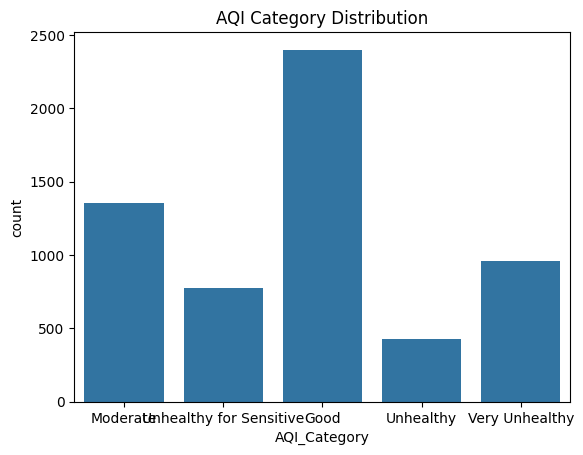

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='AQI_Category', data=df_daily)
plt.title("AQI Category Distribution")
plt.show()


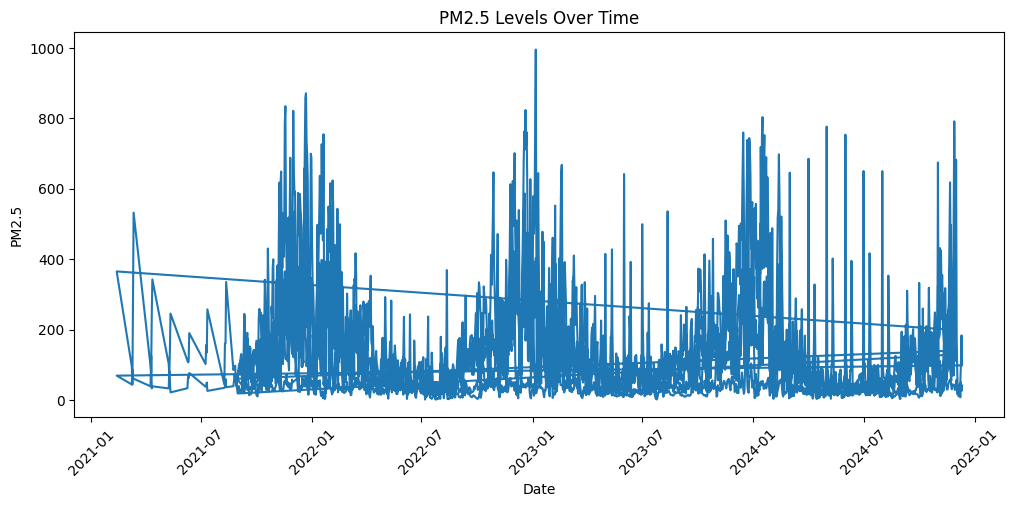

In [42]:
plt.figure(figsize=(12,5))
plt.plot(df_daily['date'], df_daily['pm2_5'])
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("PM2.5")
plt.title("PM2.5 Levels Over Time")
plt.show()


In [43]:
# Convert city names and AQI categories into numbers so the model can understand them.
from sklearn.preprocessing import LabelEncoder

le_city = LabelEncoder()
df_daily['city_encoded'] = le_city.fit_transform(df_daily['city'])

le_target = LabelEncoder()
df_daily['target'] = le_target.fit_transform(df_daily['AQI_Category'])


In [44]:
features = [
    'pm2_5_lag1', 'pm2_5_lag3', 'pm2_5_lag7',
    'pm2_5_roll3', 'pm2_5_roll7',
    'temperature', 'humidity', 'wind_speed',
    'pm10', 'no2', 'o3', 'so2', 'co',
    'city_encoded'
]

X = df_daily[features]
y = df_daily['target']


In [45]:
# Split the data into training (before 2024) and testing (2024 onwards) sets for model training and evaluation.
train = df_daily[df_daily['date'] < '2024-01-01']
test  = df_daily[df_daily['date'] >= '2024-01-01']

X_train, y_train = train[features], train['target']
X_test, y_test = test[features], test['target']


In [46]:
# Set up and train XGBoost model with 300 trees, learning rate 0.05, max depth 6, and subsampling for better accuracy.
from xgboost import XGBClassifier

model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, ...)

In [47]:
from sklearn.metrics import classification_report

pred = model.predict(X_test)
print(classification_report(y_test, pred, target_names=le_target.classes_))


                         precision    recall  f1-score   support

                   Good       0.99      0.95      0.97       865
               Moderate       0.85      0.93      0.89       358
              Unhealthy       0.86      0.93      0.89        80
Unhealthy for Sensitive       0.89      0.86      0.88       181
         Very Unhealthy       0.98      0.98      0.98       194

               accuracy                           0.94      1678
              macro avg       0.91      0.93      0.92      1678
           weighted avg       0.94      0.94      0.94      1678



In [48]:
import joblib

joblib.dump(model, "aqi_model.pkl")
joblib.dump(le_city, "city_encoder.pkl")
joblib.dump(le_target, "aqi_encoder.pkl")


['aqi_encoder.pkl']